# PROJECT-1.  Угадай знаменитость

### Основная цель — добиться accuracy > 0.85 на валидационной выборке

## Загрузка библиотек

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import time
import glob

import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import cv2

%matplotlib inline

## Загрузка данных

In [3]:
path = 'Project_1/'

# Мы создаем класс CustomDataset и передаем аргумент Dataset, 
# чтобы он мог наследовать функционал класса Torch Dataset

class CustomDataset(Dataset):
    def __init__(self, train_flag = 'train', my_path=path, fine_tuning = False):
        if train_flag == 'train':
          self.imgs_path = my_path + 'train/'
        elif train_flag == 'val':
          self.imgs_path = my_path + 'valid/'
        
        ds = ImageFolder(self.imgs_path)  
        self.data = ds.imgs


        
        self.classes = ds.classes
        self.class_map = ds.class_to_idx
        self.img_dim = (70, 70)

        # Перемешаем данные
        random.shuffle(self.data) 


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]

        # Мы используем opencv, чтобы загрузить изображение и изменить его размер до необходимого размера
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)

        # Словарь self.class_map обеспечивает отображение имени класса в метку.
        class_id = class_name
        img_tensor = torch.from_numpy(img)

        # Приведем скейлинг изображения: переведем пиксели от 0 до 255 к формату от 0 до 1 
        img_tensor = img_tensor/255
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [4]:
# Загружаем обучающую и тестовую сеты
train_data = CustomDataset()
val_data = CustomDataset('val')

batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

Посмотрим на размеры загруженных данных.

In [5]:
print('Размер тренировочной выборки {}'.format(train_data.__len__()))
print('Размер тестовой выборки {}'.format(val_data.__len__()))


Размер тренировочной выборки 3000
Размер тестовой выборки 914


Отрисуем один батч картинок, загруженных с помощью DataLoader()

In [6]:
X_train, y_train = next(iter(train_loader))
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))

In [7]:
classes = train_data.classes
classes

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

['mark_zuckerberg', 'bill_gates', 'mark_zuckerberg', 'mark_zuckerberg', 'steve_jobs', 'mark_zuckerberg', 'jeff_bezos', 'jeff_bezos', 'bill_gates', 'mark_zuckerberg', 'mark_zuckerberg', 'steve_jobs', 'jeff_bezos', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg']


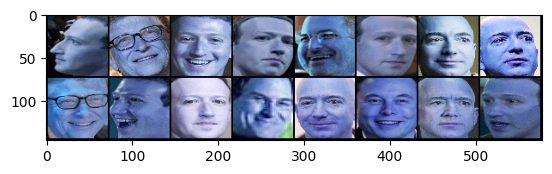

In [8]:
print([classes[i] for i in y_train])
plt.imshow(img)

### Загрузка модели

Мы будем использовать VGG16 в качестве предобученной сети.

In [9]:
from torchvision.models import vgg16

model = vgg16(pretrained = True)
print(model)

/root/miniconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Заморозка слоев VGG16 сети

In [10]:

# Настроим 3 последних сверточных слоя сети
for index, param in enumerate(model.features.parameters()):
    if index >= 24:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Посмотрим, сколько нейронов подается на вход выходному слою классификатора
n_neurons = model.classifier[-1].in_features 


# Заменим этот слой на новый, выходное количество нейронов которого соотвествует нашей задачи бинарной классификации
num_classes = len(classes)
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

print(n_neurons, num_classes)

4096 5


In [11]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)

In [13]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

True


### Обучение модели

Для удобства создадим словарь даталоадеров:

In [14]:
dataloaders = {'train': train_loader,
               'val': val_loader}

In [15]:
def train_model(model, device, dataloaders, criterion, optimizer, batch_size, fine_tuning = False, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # На каждой эпохе происходит обучение и валидая 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем лосс
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
                # посмотрим на статистики на каждых 10 батчах
                if batch%10 == 0 and phase == "train":
                  print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                  batch, current_loss/(batch_size*batch), 100*current_corrects/(batch_size*batch)))

            epoch_loss = current_loss / CustomDataset(phase, fine_tuning = fine_tuning).__len__()
            epoch_acc = current_corrects.double() / CustomDataset(phase, fine_tuning = fine_tuning).__len__()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [16]:
famous_model = train_model(model, device, dataloaders, criterion, optimizer, batch_size = batch_size, fine_tuning = False, num_epochs=5)

Epoch 0/4
----------
Batch 10, Train Loss:2.1101, Train ACC:41.2500
Batch 20, Train Loss:1.8612, Train ACC:49.6875
Batch 30, Train Loss:1.6668, Train ACC:56.2500
Batch 40, Train Loss:1.6834, Train ACC:57.8125
Batch 50, Train Loss:1.6589, Train ACC:60.0000
Batch 60, Train Loss:1.6514, Train ACC:61.4583
Batch 70, Train Loss:1.5406, Train ACC:63.1250
Batch 80, Train Loss:1.4850, Train ACC:64.8438
Batch 90, Train Loss:1.4257, Train ACC:66.1111
Batch 100, Train Loss:1.4172, Train ACC:66.6250
Batch 110, Train Loss:1.3348, Train ACC:68.4659
Batch 120, Train Loss:1.2883, Train ACC:69.3750
Batch 130, Train Loss:1.2898, Train ACC:70.0962
Batch 140, Train Loss:1.2659, Train ACC:71.1607
Batch 150, Train Loss:1.2544, Train ACC:71.6250
Batch 160, Train Loss:1.2323, Train ACC:72.3047
Batch 170, Train Loss:1.2522, Train ACC:72.5368
Batch 180, Train Loss:1.2464, Train ACC:73.0208
train Loss: 1.2343 Acc: 0.7343
val Loss: 1.3018 Acc: 0.7659
Epoch 1/4
----------
Batch 10, Train Loss:0.9322, Train ACC:82.5

Accuracy на валидационной выборке составляет 0.9311, что больше 0.85. Цель достигнута.

### Визуализация модели

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    if use_gpu:
      device = 'cuda'
    else:
      device = 'cpu'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

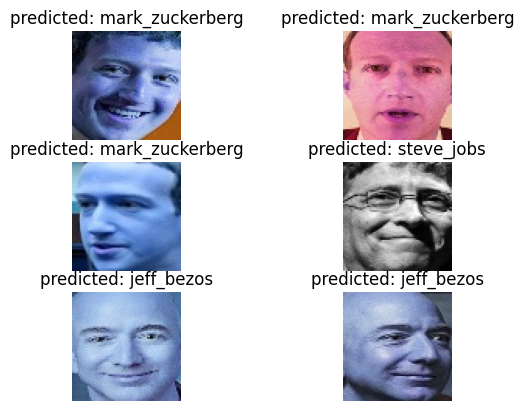

In [18]:
visualize_model(famous_model)
plt.show()